In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,preprocessing
from sklearn.preprocessing import StandardScaler
from keras.constraints import maxnorm
from keras.optimizers import RMSprop

import time
from datetime import datetime

import os
print(os.listdir("./input"))

['fundamentals.csv', 'prices-split-adjusted.csv', 'prices.csv', 'securities.csv']


In [2]:
price_df = pd.read_csv(r'./input/prices-split-adjusted.csv')
securities_df = pd.read_csv(r'./input/securities.csv')
fundamentals_df = pd.read_csv(r'./input/fundamentals.csv')

In [3]:
price_df

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0


In [4]:
securities_df

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877
...,...,...,...,...,...,...,...,...
500,YHOO,Yahoo Inc.,reports,Information Technology,Internet Software & Services,"Sunnyvale, California",NaN,1011006
501,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061
502,ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",NaN,1136869
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",NaN,109380


## Preprocessing Steps

1. Add additional features from price data
2. Apply standardisation of the train and test data

In [5]:
# Source https://blog.quantinsti.com/neural-network-python/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

In [6]:
price_df = price_df[['symbol','date','open','low','high','volume','close']]

In [7]:
# Fine Tune using FB price data
FB_prices = price_df[price_df['symbol']=='FB']
FB_prices

,symbol,date,open,low,high,volume,close
354496,FB,2013-01-02,27.440001,27.420000,28.180000,69846400.0,28.000000
354979,FB,2013-01-03,27.879999,27.590000,28.469999,63140600.0,27.770000
355462,FB,2013-01-04,28.010000,27.830000,28.930000,72715400.0,28.760000
355945,FB,2013-01-07,28.690001,28.650000,29.790001,83781800.0,29.420000
356428,FB,2013-01-08,29.510000,28.860001,29.600000,45871300.0,29.059999
...,...,...,...,...,...,...,...
848936,FB,2016-12-23,117.000000,116.300003,117.559998,10877300.0,117.269997
849436,FB,2016-12-27,116.959999,116.860001,118.680000,12027700.0,118.010002
849936,FB,2016-12-28,118.190002,116.650002,118.250000,11980200.0,116.919998
850436,FB,2016-12-29,117.000000,116.059998,117.529999,9921400.0,116.349998


In [8]:
# Shift the last row of y and remove the last observation
FB_prices['close'] = FB_prices['close'].shift(-1)
FB_prices = FB_prices.dropna()
FB_prices

<ipython-input-8-ef5ce08c8a27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FB_prices['close'] = FB_prices['close'].shift(-1)


,symbol,date,open,low,high,volume,close
354496,FB,2013-01-02,27.440001,27.420000,28.180000,69846400.0,27.770000
354979,FB,2013-01-03,27.879999,27.590000,28.469999,63140600.0,28.760000
355462,FB,2013-01-04,28.010000,27.830000,28.930000,72715400.0,29.420000
355945,FB,2013-01-07,28.690001,28.650000,29.790001,83781800.0,29.059999
356428,FB,2013-01-08,29.510000,28.860001,29.600000,45871300.0,30.590000
...,...,...,...,...,...,...,...
848436,FB,2016-12-22,118.860001,116.930000,118.989998,16222400.0,117.269997
848936,FB,2016-12-23,117.000000,116.300003,117.559998,10877300.0,118.010002
849436,FB,2016-12-27,116.959999,116.860001,118.680000,12027700.0,116.919998
849936,FB,2016-12-28,118.190002,116.650002,118.250000,11980200.0,116.349998


In [9]:
# Separate close price variable, remove ticker variable
X = FB_prices.iloc[:, 1:-1]
y = FB_prices.iloc[:, -1]
X = X.set_index('date')

In [10]:
# Split into train, validation, test sets (60:20:20)
# Split Train into Train and Validation for model tuning
np.random.seed(5004)
split = int(len(FB_prices)*0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [11]:
# Scale Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(805, 4)
(805,)
(202, 4)
(202,)


## Artificial Neural Network Implementation

Tickers:
- Facebook - FB
- Amazon - AMZN
- Apple - AAPL
- Netflix - NFLX
- Alphabet - GOOGL

## Hyperparameter Gradient Descent Tuning

I will be tuning the following:
1. Choice of optimisation for the cost function
2. Choice of kernal initialiser
3. Size of layers
4. Numer of nodes used in the neural network

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [14]:
# https://www.syncfusion.com/ebooks/keras-succinctly/regression

## Running ANN on Test Data for 5 FAANG stocks selected

Tuned model with highest MSE that will be evaluation on the 5 stocks below:

- 2 Layer ANN
- Kernal Initialisation: Uniform
- Number of Neurons: 50
- Activation Function: Linear
- Optimisation: RMSprop (learning rate 0.001, dropout rate = 0.1)

In [15]:
# Creating DatSets for Testing
# Facebook - FB
FB_prices = price_df[price_df['symbol']== 'FB']

# Separate close price variable, remove ticker variable
X_FB = FB_prices.iloc[:, 1:-1]
y_FB = FB_prices.iloc[:, -1]
X_FB = X_FB.set_index('date')

# Split Train into Train and Validation for model tuning
np.random.seed(5005)
split = int(len(FB_prices)*0.8)
FB_X_train, FB_X_test, FB_y_train, FB_y_test = X_FB[:split], X_FB[split:], y_FB[:split], y_FB[split:]

# Scale Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
FB_X_train = sc.fit_transform(FB_X_train)
FB_X_test = sc.transform(FB_X_test)
X_FB = sc.fit_transform(X_FB)
y_FB = sc.fit_transform(X_FB)

In [16]:
# Amazon - AMZN
AMZN_prices = price_df[price_df['symbol']== 'AMZN']

# Separate close price variable, remove ticker variable
X_AMZN = AMZN_prices.iloc[:, 1:-1]
y_AMZN = AMZN_prices.iloc[:, -1]
X_AMZN = X_AMZN.set_index('date')

# Split Train into Train and Validation for model tuning
np.random.seed(5006)
split = int(len(AMZN_prices)*0.8)
AMZN_X_train, AMZN_X_test, AMZN_y_train, AMZN_y_test = X_AMZN[:split], X_AMZN[split:], y_AMZN[:split], y_AMZN[split:]

# Scale Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
AMZN_X_train = sc.fit_transform(AMZN_X_train)
AMZN_X_test = sc.transform(AMZN_X_test)
X_AMZN = sc.fit_transform(X_AMZN)

In [17]:
# Apple - AAPL
AAPL_prices = price_df[price_df['symbol']== 'AAPL']

# Separate close price variable, remove ticker variable
X_AAPL = AAPL_prices.iloc[:, 1:-1]
y_AAPL = AAPL_prices.iloc[:, -1]
X_AAPL = X_AAPL.set_index('date')

# Split Train into Train and Validation for model tuning
np.random.seed(5007)
split = int(len(AAPL_prices)*0.8)
AAPL_X_train, AAPL_X_test, AAPL_y_train, AAPL_y_test = X_AAPL[:split], X_AAPL[split:], y_AAPL[:split], y_AAPL[split:]

# Scale Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
AAPL_X_train = sc.fit_transform(AAPL_X_train)
AAPL_X_test = sc.transform(AAPL_X_test)
X_AAPL = sc.fit_transform(X_AAPL)

In [18]:
# Netflix - NFLX
NFLX_prices = price_df[price_df['symbol']== 'NFLX']

# Separate close price variable, remove ticker variable
X_NFLX = NFLX_prices.iloc[:, 1:-1]
y_NFLX = NFLX_prices.iloc[:, -1]
X_NFLX = X_NFLX.set_index('date')

# Split Train into Train and Validation for model tuning
np.random.seed(5008)
split = int(len(NFLX_prices)*0.8)
NFLX_X_train, NFLX_X_test, NFLX_y_train, NFLX_y_test =X_NFLX[:split], X_NFLX[split:], y_NFLX[:split], y_NFLX[split:]

# Scale Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
NFLX_X_train = sc.fit_transform(NFLX_X_train)
NFLX_X_test = sc.transform(NFLX_X_test)
X_NFLX = sc.fit_transform(X_NFLX)

In [19]:
# Alphabet - GOOGL
GOOGL_prices = price_df[price_df['symbol']== 'GOOGL']

# Separate close price variable, remove ticker variable
X_GOOGL = GOOGL_prices.iloc[:, 1:-1]
y_GOOGL = GOOGL_prices.iloc[:, -1]
X_GOOGL = X_GOOGL.set_index('date')

# Split Train into Train and Validation for model tuning
np.random.seed(5009)
split = int(len(GOOGL_prices)*0.8)
GOOGL_X_train, GOOGL_X_test, GOOGL_y_train, GOOGL_y_test = X_GOOGL[:split], X_GOOGL[split:], y_GOOGL[:split], y_GOOGL[split:]

# Scale Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
GOOGL_X_train = sc.fit_transform(GOOGL_X_train)
GOOGL_X_test = sc.transform(GOOGL_X_test)
X_GOOGL = sc.fit_transform(X_GOOGL)

### Test Set Evaluation

In [20]:
# Evaluation Functions
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [21]:
# FB Test Evaluation
# Testing R squared on 1 layer ANN
# https://github.com/keras-team/keras/issues/7947
def ann_rss():
    model = Sequential()
    model.add(Dense(units=100, kernel_initializer='normal', input_dim=FB_X_train.shape[1], activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    # Optimise gradient descent
    optimizer = RMSprop(lr=0.001)
    model.compile(loss="mean_squared_error", optimizer='Adam', metrics=["mean_squared_error",rmse,r_square])
    return model

model = Sequential()
model.add(Dense(units=100, kernel_initializer='normal', input_dim=FB_X_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
# Compile model
# Optimise gradient descent
optimizer = RMSprop(lr=0.001)
model.compile(loss="mean_squared_error", optimizer='Adam', metrics=["mean_squared_error",rmse,r_square])

t0=datetime.now()

np.random.seed(5010)
FB_history = model.fit(FB_X_train, FB_y_train, epochs=100, batch_size=5,verbose=0)
FB_results = model.evaluate(FB_X_test, FB_y_test)
FB_predictions = model.predict(FB_X_test)

estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=ann_rss, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

# Cross Validation Score
kfold = KFold(n_splits=10)
FB_CV_results = (-cross_val_score(pipeline, X = X_FB, y = y_FB, cv=kfold)).mean()

# Computing MSE
print("Time to compute accuracy: ",(datetime.now()-t0))
print("Loss:, MSE:, RMSE:, R-square: ", FB_results)
print("Cross Validation Score: ", FB_CV_results)

7/7 [==============================] - 0s 718us/step - loss: 2.5702 - mean_squared_error: 2.5702 - rmse: 1.4421 - r_square: 0.2413
Time to compute accuracy:  0:01:58.799140
Loss:, MSE:, RMSE:, R-square:  [2.5702009201049805, 2.5702009201049805, 1.442126750946045, 0.24132438004016876]
Cross Validation Score:  0.7896709121763706


In [22]:
# AMZN Test Evaluation

model = Sequential()
model.add(Dense(units=100, kernel_initializer='normal', input_dim=FB_X_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
# Compile model
# Optimise gradient descent
optimizer = RMSprop(lr=0.001)
model.compile(loss="mean_squared_error", optimizer='Adam', metrics=["mean_squared_error",rmse,r_square])

t0=datetime.now()

np.random.seed(5011)
AMZN_history = model.fit(AMZN_X_train, AMZN_y_train, epochs=100, batch_size=5,verbose=0)
AMZN_results = model.evaluate(AMZN_X_test, AMZN_y_test)
AMZN_predictions = model.predict(AMZN_X_test)

estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=ann_rss, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

# Cross Validation Score
kfold = KFold(n_splits=10)
AMZN_CV_results = (-cross_val_score(pipeline, X = X_AMZN, y = y_AMZN, cv=kfold)).mean()
CV_test=cross_val_score(pipeline, X = X_AMZN, y = y_AMZN, cv=kfold)

# Computing MSE
print("Time to compute accuracy: ",(datetime.now()-t0))
print("Loss:, MSE:, RMSE:, R-square: ", AMZN_results)
print("Cross Validation Score: ", AMZN_CV_results)

12/12 [==============================] - 0s 665us/step - loss: 30.7286 - mean_squared_error: 30.7286 - rmse: 4.4139 - r_square: -96438824.0000
Time to compute accuracy:  0:06:01.177038
Loss:, MSE:, RMSE:, R-square:  [30.728614807128906, 30.728614807128906, 4.413888931274414, -96438824.0]
Cross Validation Score:  18.32960729598999


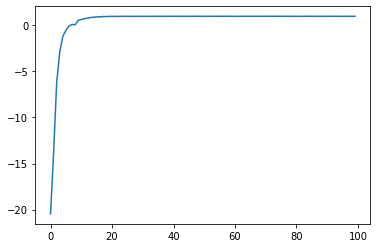

In [23]:
plt.plot(AMZN_history.history['r_square'])

In [24]:
CV_test

array([-18.68632507,  -3.781703  ,  -8.87537575,  -5.169312  ,
        -6.56843138,  -9.55179501, -10.20874691, -22.4377079 ,
       -45.60552597, -42.67290878])

In [25]:
# AAPL Test Evaluation

model = Sequential()
model.add(Dense(units=100, kernel_initializer='normal', input_dim=FB_X_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
# Compile model
# Optimise gradient descent
optimizer = RMSprop(lr=0.001)
model.compile(loss="mean_squared_error", optimizer='Adam', metrics=["mean_squared_error",rmse,r_square])

t0=datetime.now()

np.random.seed(5012)
AAPL_history = model.fit(AAPL_X_train, AAPL_y_train, epochs=100, batch_size=5,verbose=0)
AAPL_results = model.evaluate(AAPL_X_test, AAPL_y_test)
AAPL_predictions = model.predict(AAPL_X_test)

estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=ann_rss, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

# Cross Validation Score
kfold = KFold(n_splits=10)
AAPL_CV_results = (-cross_val_score(pipeline, X = X_AAPL, y = y_AAPL, cv=kfold)).mean()

# Computing MSE
print("Time to compute accuracy: ",(datetime.now()-t0))
print("Loss:, MSE:, RMSE:, R-square: ", AAPL_results)
print("Cross Validation Score: ", AAPL_CV_results)

12/12 [==============================] - 0s 665us/step - loss: 0.8191 - mean_squared_error: 0.8191 - rmse: 0.6850 - r_square: -60336.2539
Time to compute accuracy:  0:02:57.032816
Loss:, MSE:, RMSE:, R-square:  [0.819106936454773, 0.819106936454773, 0.6849704384803772, -60336.25390625]
Cross Validation Score:  0.7294233053922653


In [26]:
# NFLX Test Evaluation

model = Sequential()
model.add(Dense(units=100, kernel_initializer='normal', input_dim=FB_X_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
# Compile model
# Optimise gradient descent
optimizer = RMSprop(lr=0.001)
model.compile(loss="mean_squared_error", optimizer='Adam', metrics=["mean_squared_error",rmse,r_square])

t0=datetime.now()

NFLX_history = model.fit(NFLX_X_train, NFLX_y_train, epochs=100, batch_size=5,verbose=0)
NFLX_results = model.evaluate(NFLX_X_test, NFLX_y_test)
NFLX_predictions = model.predict(NFLX_X_test)

np.random.seed(5013)
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=ann_rss, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

# Cross Validation Score
kfold = KFold(n_splits=10)
NFLX_CV_results = (-cross_val_score(pipeline, X = X_NFLX, y = y_NFLX, cv=kfold)).mean()

# Computing MSE
print("Time to compute accuracy: ",(datetime.now()-t0))
print("Loss:, MSE:, RMSE:, R-square: ", NFLX_results)
print("Cross Validation Score: ", NFLX_CV_results)

12/12 [==============================] - 0s 831us/step - loss: 2.2374 - mean_squared_error: 2.2374 - rmse: 1.1291 - r_square: -3117669.2500
Time to compute accuracy:  0:03:00.280770
Loss:, MSE:, RMSE:, R-square:  [2.237445116043091, 2.237445116043091, 1.1291042566299438, -3117669.25]
Cross Validation Score:  0.8877123214304448


In [27]:
# GOOGL Test Evaluation

model = Sequential()
model.add(Dense(units=100, kernel_initializer='normal', input_dim=FB_X_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
# Compile model
# Optimise gradient descent
optimizer = RMSprop(lr=0.001)
model.compile(loss="mean_squared_error", optimizer='Adam', metrics=["mean_squared_error",rmse,r_square])

t0=datetime.now()
np.random.seed(5014)

GOOGL_history = model.fit(GOOGL_X_train, GOOGL_y_train, epochs=100, batch_size=5,verbose=0)
GOOGL_results = model.evaluate(GOOGL_X_test, GOOGL_y_test)
GOOGL_predictions = model.predict(GOOGL_X_test)

estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=ann_rss, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

# Cross Validation Score
kfold = KFold(n_splits=10)
GOOGL_CV_results = (-cross_val_score(pipeline, X = X_GOOGL, y = y_GOOGL, cv=kfold)).mean()

# Computing MSE
print("Time to compute accuracy: ",(datetime.now()-t0))
print("Loss:, MSE:, RMSE:, R-square: ", GOOGL_results)
print("Cross Validation Score: ", GOOGL_CV_results)

12/12 [==============================] - 0s 666us/step - loss: 32.9280 - mean_squared_error: 32.9280 - rmse: 4.4565 - r_square: -11851109.0000
Time to compute accuracy:  0:02:59.968202
Loss:, MSE:, RMSE:, R-square:  [32.92803192138672, 32.92803192138672, 4.456546306610107, -11851109.0]
Cross Validation Score:  19.098121929168702


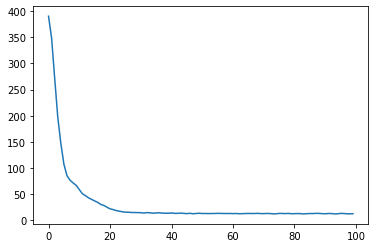

In [28]:
plt.plot(GOOGL_history.history['rmse'])

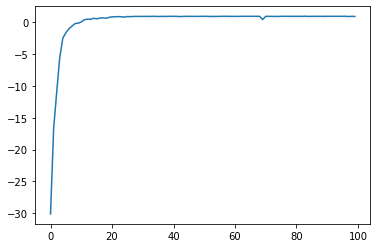

In [29]:
plt.plot(GOOGL_history.history['r_square'])

In [30]:
# Convert predicted arrays to lists
FB_predictions=FB_predictions.flatten()
AMZN_predictions=AMZN_predictions.flatten()
AAPL_predictions=AAPL_predictions.flatten()
NFLX_predictions=NFLX_predictions.flatten()
GOOGL_predictions=GOOGL_predictions.flatten()

FB_predictions = pd.Series(FB_predictions)
AMZN_predictions = pd.Series(AMZN_predictions)
AAPL_predictions = pd.Series(AAPL_predictions)
NFLX_predictions = pd.Series(NFLX_predictions)
GOOGL_predictions = pd.Series(GOOGL_predictions)

# Convert to list
FB_predictions = pd.Series(FB_predictions)
AMZN_predictions = pd.Series(AMZN_predictions)
AAPL_predictions = pd.Series(AAPL_predictions)
NFLX_predictions = pd.Series(NFLX_predictions)
GOOGL_predictions = pd.Series(GOOGL_predictions)

FB_y_test=pd.Series.tolist(FB_y_test)
AMZN_y_test=pd.Series.tolist(AMZN_y_test)
AAPL_y_test=pd.Series.tolist(AAPL_y_test)
NFLX_y_test=pd.Series.tolist(NFLX_y_test)
GOOGL_y_test=pd.Series.tolist(GOOGL_y_test)

### Comparison Graphs Actual v Predicted

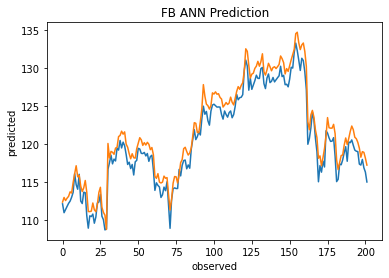

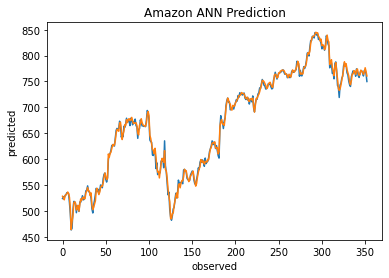

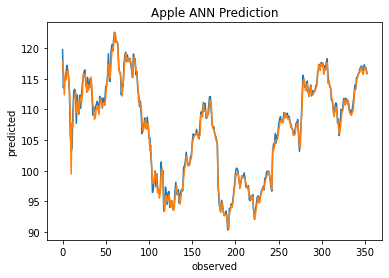

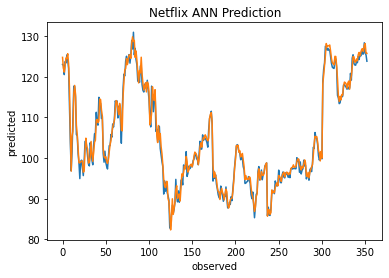

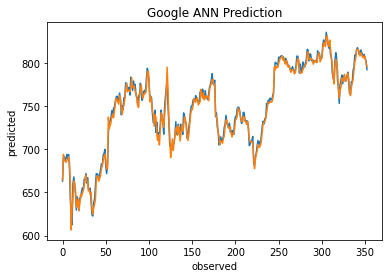

In [31]:
# Plot FB actual v predicted price
line_chart1 = plt.plot(FB_y_test)
line_chart2 = plt.plot(FB_predictions)
plt.title('FB ANN Prediction')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

# Plot Amazon actual v predicted price
line_chart1 = plt.plot(AMZN_y_test)
line_chart2 = plt.plot(AMZN_predictions)
plt.title('Amazon ANN Prediction')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

# Plot Apple actual v predicted price
line_chart1 = plt.plot(AAPL_y_test)
line_chart2 = plt.plot(AAPL_predictions)
plt.title('Apple ANN Prediction')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

# Plot Netflix actual v predicted price
line_chart1 = plt.plot(NFLX_y_test)
line_chart2 = plt.plot(NFLX_predictions)
plt.title('Netflix ANN Prediction')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

# Plot Google actual v predicted price
line_chart1 = plt.plot(GOOGL_y_test)
line_chart2 = plt.plot(GOOGL_predictions)
plt.title('Google ANN Prediction')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

In [32]:
Stop Here!

SyntaxError: invalid syntax (<ipython-input-32-b67d92fecaf0>, line 1)

## Hardware and Software Specifications 

Processor	Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, 1800 Mhz, 4 Core(s), 8 Logical Processor(s)

## Summary
On the test set evaluation the stock had the highest cross validation R-squared score was with a R-square value of 54.90. Meaning the ANN explains % of the stock price variability.

## Hyperparameter Gradient Descent Tuning

In [ ]:
# Grid Search of Tuning
# Source: https://towardsdatascience.com/ann-classification-model-evaluation-and-parameter-tuning-9174fd5ad0c2
# https://blogs.oracle.com/meena/simple-neural-network-model-using-keras-and-grid-search-hyperparameterstuning
np.random.seed(5002)

from sklearn.model_selection import GridSearchCV

def ann_grid(optimizer='adam', units = 5, kernel_initializer='normal',activation='relu'):
    # create model
    model = Sequential()
    model.add(Dense(units=units, kernel_initializer=kernel_initializer, input_dim=X.shape[1], activation=activation))
    model.add(Dropout(rate=0.1))
    model.add(Dense(1, kernel_initializer=kernel_initializer, activation=activation))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    return model

model = KerasRegressor(build_fn=ann_grid, epochs=100, batch_size=5, verbose=0)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']
units=[10, 20, 50, 100]
kernel_initializer=['uniform','normal','zero']
activation=['relu', 'tanh', 'linear','sigmoid']

param_grid = dict(optimizer=optimizer, units=units, kernel_initializer=kernel_initializer, activation=activation)

kfold = KFold(n_splits=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# 2 Layer ANN
# Optimising Learning Rate of Optimiser
np.random.seed(5002)

from sklearn.model_selection import GridSearchCV
from keras.optimizers import RMSprop

def ann_grid(optimizer='Adam', units = 100, kernel_initializer='normal',activation='relu',lr=0.1, epsilon=0.1,rate=0.1):
    # create model
    model = Sequential()
    model.add(Dense(units=units, kernel_initializer=kernel_initializer, input_dim=X.shape[1], activation=activation))
    model.add(Dense(units=units, activation=activation)) # second layer
    model.add(Dropout(rate=rate))
    model.add(Dense(1, kernel_initializer=kernel_initializer, activation=activation))
    # Compile model
    # Optimise gradient descent
    optimizer = RMSprop(lr=lr, epsilon=epsilon)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    return model

model = KerasRegressor(build_fn=ann_grid, epochs=100, batch_size=5, verbose=0)

#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']
#units=[10, 20, 50, 100]
#kernel_initializer=['uniform','normal','zero']
#activation=['relu', 'tanh', 'linear','sigmoid']

lr=[0.0001, 0.001, 0.1,1,5]
epsilon=[0.001, 0.1,1]
rate=[0.1,0.2,0.5]
optimizer = ['Adam']

param_grid = dict(lr=lr, epsilon=epsilon,rate=rate,optimizer=optimizer)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# 5 Layer ANN
# Optimising Learning Rate of Optimiser
np.random.seed(5002)

from sklearn.model_selection import GridSearchCV
from keras.optimizers import RMSprop
from keras import backend as K

def ann_grid(optimizer='Adam', units = 100, kernel_initializer='normal',activation='relu',lr=0.1, epsilon=0.1,rate=0.1):
    # create model
    model = Sequential()
    model.add(Dense(units=units, kernel_initializer=kernel_initializer, input_dim=X.shape[1], activation=activation))
    model.add(Dropout(rate=rate))
    model.add(Dense(units=units, activation=activation)) # second layer
    model.add(Dropout(rate=rate))
    model.add(Dense(units=units, activation=activation)) # third layer
    model.add(Dropout(rate=rate))
    model.add(Dense(units=units, activation=activation)) # fourth layer
    model.add(Dropout(rate=rate))
    model.add(Dense(units=units, activation=activation)) # fifth layer
    model.add(Dropout(rate=rate))
    model.add(Dense(1, kernel_initializer=kernel_initializer, activation=activation))
    # Compile model
    # Optimise gradient descent
    optimizer = RMSprop(lr=lr, epsilon=epsilon)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    return model

def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

model = KerasRegressor(build_fn=ann_grid, epochs=100, batch_size=5, verbose=0)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']
units=[10, 20, 50, 100]
kernel_initializer=['uniform','normal','zero']
activation=['relu', 'tanh', 'linear','sigmoid']

param_grid = dict(optimizer=optimizer, units=units, kernel_initializer=kernel_initializer, activation=activation)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Additional Graphs

In [ ]:
# Plot FB actual v predicted price
plt.scatter(FB_y_test, FB_predictions, color='blue', label= 'data')
plt.title('FB ANN Prediction')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

# Plot Google actual v predicted price
plt.scatter(AMZN_y_test, AMZN_predictions, color='blue', label= 'data')
plt.title('Amazon ANN Prediction')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

# Plot Google actual v predicted price
plt.scatter(AAPL_y_test, AAPL_predictions, color='blue', label= 'data')
plt.title('Apple ANN Prediction')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

# Plot Google actual v predicted price
plt.scatter(NFLX_y_test, NFLX_predictions, color='blue', label= 'data')
plt.title('Netflix ANN Prediction')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

# Plot Google actual v predicted price
plt.scatter(GOOGL_y_test, GOOGL_predictions, color='blue', label= 'data')
plt.title('Google ANN Prediction')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()